In [1]:
import pyomo.environ as pyo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from readData import *
from rent_estimation import calculate_rent_estimation

NUMBER_OF_COUNTIES = 3130

In [2]:
budget = 1e50
N = 4000
risk = 0.8

print(budget, N, risk)

1e+50 4000 0.8


In [3]:
income = getIncome()
income.drop(['MedianIncome','MedianIncomeRatio'],axis=1,inplace=True)
populations = getPopulation()
populations = populations[['State','County','2024']]
populations.rename({'2024':'Population'},axis=1,inplace=True)
rent = calculate_rent_estimation()
rent = rent[['State','County','Estimated_annual_rent']]
minwage = getMinWage()

data = populations.merge(income)
data = data.merge(rent)
data = data.merge(minwage)
data[' MinWage'] = data[' MinWage'] \
    .str.replace(' 15.50/16.50', ' 16.50') \
    .str.strip()
data[' MinWage'] = data[' MinWage'].astype(float)
data.rename(columns={
    ' MinWage':'MinWage',
}, inplace=True)



data['id'] = data['CountyID'].apply(lambda x: int(x[-5:]))
restaurant = getLValues()
data = data.merge(
    restaurant[['fips','totalRestaurants', 'L']],
    left_on='id',
    right_on='fips'
)
print("Number counties with no restuarant data",data.loc[data['totalRestaurants']==0].shape[0])

data.loc[data['totalRestaurants']==0,'totalRestaurants'] = data['totalRestaurants'].mean()
data

c:\MY FILES\UMD\Sem 4\MSML604 Optimization\Project\optimization-location-intelligence\rent_estimation.py:110: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df['Commercial_rent_per_sqft_year'].fillna(avg_rent_per_sqft, inplace=True)
c:\MY FILES\UMD\Sem 4\MSML604 Optimization\Project\optimization-location-intelligence\rent_estimation.py:111: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace 

Average Rent Per Sqft: 92.93
Average Annual Rent: 185857.18
Number counties with no restuarant data 39


C:\Users\Peeyush\AppData\Local\Temp\ipykernel_34256\2159261835.py:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '302.75495207667734' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[data['totalRestaurants']==0,'totalRestaurants'] = data['totalRestaurants'].mean()


,State,County,Population,CountyID,MeanIncome,MeanIncomeRatio,Estimated_annual_rent,MinWage,id,fips,totalRestaurants,L
0,Alabama,Autauga,61464,0500000US01001,93367,0.411925,184682.27,7.25,1001,1001,219.0,1.212828e+07
1,Alabama,Baldwin,261608,0500000US01003,100105,0.441653,282247.68,7.25,1003,1003,409.0,8.704752e+07
2,Alabama,Barbour,24358,0500000US01005,64745,0.285648,106381.32,7.25,1005,1005,56.0,1.420327e+06
3,Alabama,Bibb,22258,0500000US01007,67735,0.298840,146669.94,7.25,1007,1007,149.0,3.351553e+06
4,Alabama,Blount,60163,0500000US01009,79203,0.349435,168697.13,7.25,1009,1009,550.0,3.172463e+07
...,...,...,...,...,...,...,...,...,...,...,...,...
3125,Wyoming,Sweetwater,41273,0500000US56037,98608,0.435048,211876.05,7.25,56037,56037,125.0,5.440183e+06
3126,Wyoming,Teton,23272,0500000US56039,185173,0.816964,1621554.10,7.25,56039,56039,4.0,9.315185e+04
3127,Wyoming,Uinta,20621,0500000US56041,89995,0.397048,235265.57,7.25,56041,56041,63.0,1.290231e+06
3128,Wyoming,Washakie,7662,0500000US56043,80444,0.354910,184506.77,7.25,56043,56043,29.0,2.328395e+05


In [4]:
P = 20
revenue = data['L'] * np.exp(-0.003 * P**2) * P**(data['MeanIncomeRatio']**0.5)
costs = data['MinWage'] * 15 + data['Estimated_annual_rent'] +  0.082 * revenue
beta2 = 0.8 - costs / revenue
beta2.min(), beta2.max(), len(beta2[beta2 > 0])

(np.float64(-3968.9218506930947), np.float64(0.7179982465114896), 2824)

In [5]:
budget = 1e50
(costs <= budget).count()
costs[costs <= budget].sum()

np.float64(132423048341.31236)

In [6]:
cond = beta2[beta2> 0]


In [7]:
profit = revenue - costs
profit.min(), profit.max(), profit[(0 < profit) & (profit < 1e9)].count()

real_profit = profit[(0 < profit) & (profit < 1e9)]


In [8]:
costs.min(), costs.max(), costs.sum(), costs[costs < 1e9].count()

(np.float64(36171.72587755491),
 np.float64(10754188204.751442),
 np.float64(132423048341.31236),
 np.int64(3103))

In [9]:
totalPop = data['Population']
IR = data['MeanIncomeRatio']
minwage = data['MinWage']
rent = data['Estimated_annual_rent']
totalRestaurants = data['totalRestaurants'].astype(int)
L = data['L']

In [10]:
model = pyo.ConcreteModel()
model.counties = pyo.RangeSet(0, NUMBER_OF_COUNTIES - 1) # Number of counties
model.x = pyo.Var(model.counties, 
                #   domain=pyo.NonNegativeIntegers, 
                  domain=pyo.NonNegativeReals,
                  name='x') # Number of stores in each county
# model.x = pyo.Param(model.counties,
#                   initialize=np.ones(NUMBER_OF_COUNTIES), 
#                   name='x') # Number of stores in each county
model.P = pyo.Var(model.counties, 
                #   domain=pyo.NonNegativeIntegers, 
                  domain=pyo.NonNegativeReals,
                  name='P',
                  bounds=(1, 200)) # Price in each county
model.budget = pyo.Param(initialize=budget) # Budget for owning restaurants
model.N = pyo.Param(initialize=N) # Maximum number of stores to open
model.risk = pyo.Param(initialize=risk) # Total acceptable risk ratio per location (cost/revenue)
model.totalPop = pyo.Param(model.counties, initialize=totalPop) # Total population in county
model.IR = pyo.Param(model.counties, initialize=IR) # Income Ratio relative to maximum county income
model.minwage = pyo.Param(model.counties, initialize=minwage) # Minimum wage in county
model.rent = pyo.Param(model.counties, initialize=rent) # Rent of restaurant
model.employees = pyo.Param(initialize=15) # Number of employees in restaurant
model.totalRestaurants = pyo.Param(model.counties, initialize=totalRestaurants) # Total number of restaurants in county
model.L = pyo.Param(model.counties, initialize=L) # L value of county

C:\Users\Peeyush\AppData\Local\Temp\ipykernel_34256\820381969.py:4: RuntimeWarning: overflow encountered in exp
  func = lambda x:  1 / (1 + np.exp(-k_val * (x - 0.9)))


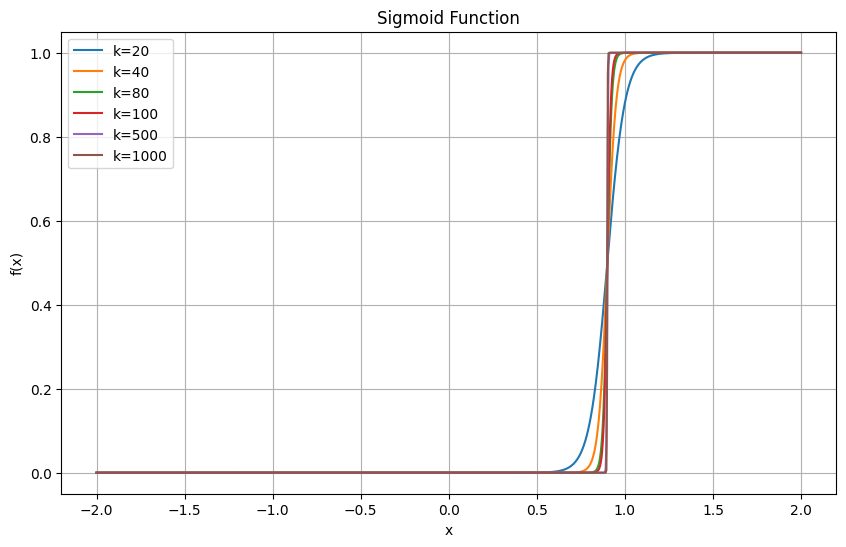

In [11]:
k = [20, 40, 80, 100, 500, 1000]
plt.figure(figsize=(10, 6))
for k_val in k:
    func = lambda x:  1 / (1 + np.exp(-k_val * (x - 0.9)))
    points = np.linspace(-2, 2, 1000)
    func_values = func(points)
    plt.plot(points, func_values, label=f'k={k_val}')   
    # plt.legend([f'k={k_val}'])
plt.title('Sigmoid Function')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.grid()
plt.legend()
plt.show()

In [12]:
def step_function(i, point=0, k=50):
    return 1 / (1 + pyo.exp(-k * (i - point)))

model.del_component('demand')  # Remove the existing demand component if it exists
def demand_rule(model, i):
    # Calculate demand based on the given formula
    return step_function(model.x[i], point=0.9) \
        * model.L[i] * pyo.exp(-0.003 * model.P[i]**2)

model.demand = pyo.Expression(model.counties, rule=demand_rule)

```python
for i in model.component_objects(pyo.Expression, active=True):
    print(i)
```

In [13]:
model.del_component('revenue')
def revenue_rule(model, i):
    # Calculate revenue based on the given formula
    return model.P[i]**(pyo.sqrt(model.IR[i])) * model.demand[i]

model.revenue = pyo.Expression(model.counties, rule=revenue_rule)

In [14]:
model.del_component('loss')
def loss_rule(model, i):
    # Calculate losses based on the given formula
    return 0.082 * model.revenue[i]

model.loss = pyo.Expression(model.counties, rule=loss_rule)

model.del_component('costs')
def costs_rule(model, i):
    # Calculate costs based on the given formula
    return step_function(model.x[i], point=0.9) \
        * (model.minwage[i] * model.employees \
            + model.rent[i] + model.loss[i])

model.costs = pyo.Expression(model.counties, rule=costs_rule)

In [15]:
model.del_component('budget_constraint')
def budget_constraint_rule(model):
    # Calculate total costs based on the given formula
    return model.budget - sum(step_function(model.x[i], point=0.9)
                              * model.x[i] * model.costs[i] 
                              for i in model.counties) >= 0

model.budget_constraint = pyo.Constraint(
    rule=budget_constraint_rule
) # Budget constraint

model.del_component('total_stores_constraint')
def total_stores_constraint_rule(model):
    return model.N - sum(step_function(model.x[i], point=0.9) 
                         * model.x[i] 
                         for i in model.counties) >= 0

model.total_stores_constraint = pyo.Constraint(
    rule=total_stores_constraint_rule
) # Maximum number of stores constraint

model.del_component('risk_constraint')
def risk_constraint_rule(model, i):
    # Calculate total revenue based on the given formula
    return model.risk * model.revenue[i] - model.costs[i] >= 1e-2

model.risk_constraint = pyo.Constraint(
    model.counties,
    rule=risk_constraint_rule
) # Risk constraint

# model.c.add(model.x >= 0) # Number of stores must be positive
# model.c.add(model.P >= 10) # Price must be positive
# model.c.add(model.P <= 50) # Price must be positive

In [16]:
model.del_component('objective')

def objective_rule(model):
    # Calculate the objective function based on the given formula
    return sum(step_function(model.x[i], point=0.9) *
               model.x[i] * (model.revenue[i] - model.costs[i])
            for i in model.counties) 

model.objective = pyo.Objective(
    rule=objective_rule,
    sense=pyo.maximize
) # Get objective function

In [ ]:
solver = pyo.SolverFactory('ipopt') # Create solver
result = solver.solve(model, tee=True) # Solve the model
print("Status:", result.solver.termination_condition)

Ipopt 3.14.17: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:    15650
Number of nonzeros in Lagrangian Hessian.............:     9390

Total number of variables............................:     6260
                     variables with only lower bounds:     3130
                variables with lower and upper bounds:     3130
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number

In [62]:
print("Objective value:", pyo.value(model.objective))
print("Total budget used:",
    f"${pyo.value(sum(model.x[i] * model.costs[i] for i in model.counties))}")
print("Total number of stores opened:",
    f"{pyo.value(sum(model.x[i] for i in model.counties))} stores")
print("Total risk ratio:",
    f"{pyo.value(sum(model.costs[i] / model.revenue[i] for i in model.counties))}")
print("Total number of counties with stores:",
    f"{len([i for i in model.counties if pyo.value(model.x[i]) > 0])} counties")
print("Total number of counties without stores:",
    f"{len([i for i in model.counties if pyo.value(model.x[i]) == 0])} counties")
print("Total number of counties with revenue:",
    f"{len([i for i in model.counties if pyo.value(model.revenue[i]) > 0])} counties")
print("Total number of counties without revenue:",
    f"{len([i for i in model.counties if pyo.value(model.revenue[i]) == 0])} counties")
print("Total number of counties with loss:",
    f"{len([i for i in model.counties if pyo.value(model.loss[i]) > 0])} counties")
print("Total number of counties without loss:",
    f"{len([i for i in model.counties if pyo.value(model.loss[i]) == 0])} counties")
print("Total number of counties with costs:",
    f"{len([i for i in model.counties if pyo.value(model.costs[i]) > 0])} counties")
print("Total number of counties without costs:",
    f"{len([i for i in model.counties if pyo.value(model.costs[i]) == 0])} counties")
print("Total number of counties with budget:",
    f"{len([i for i in model.counties if pyo.value(model.budget) > 0])} counties")
print("Total number of counties without budget:",
    f"{len([i for i in model.counties if pyo.value(model.budget) == 0])} counties")
print("Total number of counties with risk:",
    f"{len([i for i in model.counties if pyo.value(model.risk) > 0])} counties")
print("Total number of counties without risk:",
    f"{len([i for i in model.counties if pyo.value(model.risk) == 0])} counties")
print("Total number of counties with total population:",
    f"{len([i for i in model.counties if pyo.value(model.totalPop[i]) > 0])} counties")
print("Total number of counties without total population:",
    f"{len([i for i in model.counties if pyo.value(model.totalPop[i]) == 0])} counties")
print("Total number of counties with income ratio:",
    f"{len([i for i in model.counties if pyo.value(model.IR[i]) > 0])} counties")
print("Total number of counties without income ratio:",
    f"{len([i for i in model.counties if pyo.value(model.IR[i]) == 0])} counties")


Objective value: 530809954310.23535
Total budget used: $48015653516.90391
Total number of stores opened: 3130.0 stores
Total risk ratio: 33473.57711949196
Total number of counties with stores: 3130 counties
Total number of counties without stores: 0 counties
Total number of counties with revenue: 3130 counties
Total number of counties without revenue: 0 counties
Total number of counties with loss: 3130 counties
Total number of counties without loss: 0 counties
Total number of counties with costs: 3130 counties
Total number of counties without costs: 0 counties
Total number of counties with budget: 3130 counties
Total number of counties without budget: 0 counties
Total number of counties with risk: 3130 counties
Total number of counties without risk: 0 counties
Total number of counties with total population: 3130 counties
Total number of counties without total population: 0 counties
Total number of counties with income ratio: 3130 counties
Total number of counties without income ratio: 

In [64]:
x_values = np.array([pyo.value(model.x[i]) for i in model.counties])
P_values = np.array([pyo.value(model.P[i]) for i in model.counties])
revenue_values = np.array([pyo.value(model.revenue[i]) for i in model.counties])
costs_values = np.array([pyo.value(model.costs[i]) for i in model.counties])
loss_values = np.array([pyo.value(model.loss[i]) for i in model.counties])  

In [67]:
revenue_values

array([12171037.43225948, 87395878.01133843,  1422148.43962448, ...,
        1294476.8737979 ,   255308.96348646,   236512.80319909],
      shape=(3130,))

In [68]:
costs_values

array([1174899.67768777, 7398964.59563625,  221613.02523089, ...,
        339235.67167548,  204175.13377598,  189189.17324023],
      shape=(3130,))

In [69]:
revenue_values - costs_values 

array([1.09961378e+07, 7.99969134e+07, 1.20053541e+06, ...,
       9.55241202e+05, 5.11338297e+04, 4.73236300e+04], shape=(3130,))

In [ ]:
def numpy_step_function(x_values, point=1, k=50):
    return 1 / (1 + np.exp(-k * (x_values - point)))

In [ ]:
x_values, numpy_step_function(x_values, point=1)

(array([0.00031915, 0.00031923, 0.00031913, ..., 0.00031913, 0.00031913,
        0.00031913], shape=(3130,)),
 array([1.95977431e-22, 1.95978224e-22, 1.95977321e-22, ...,
        1.95977323e-22, 1.95977312e-22, 1.95977312e-22], shape=(3130,)))

In [ ]:
(revenue_values > costs_values).any()

np.True_